# `DEPRESJON` - Exploring Gender Specific Machine Learning Models
## Exploratory Data Analysis

>Garcia-Ceja, E., Riegler, M., Jakobsen, P., Tørresen, J., Nordgreen, T., Oedegaard, K.J. and Fasmer, O.B. (2018) Depresjon: a motor activity database of depression episodes in unipolar and bipolar patients. In: Proceedings of the 9th ACM Multimedia Systems Conference [online]MMSys ’18: 9th ACM Multimedia Systems Conference. Amsterdam Netherlands: ACM, pp. 472–477. Available from: https://dl.acm.org/doi/10.1145/3204949.3208125 [Accessed 2 December 2023].

**Objectives**

* Preprocessing
* Exploratory Data Analysis

**Files in Series**

* [wiki-08-base-1-eda](.\wiki-08-base-1-eda.ipynb)
* [wiki-08-base-2-person-days-rows](.\wiki-08-base-2-person-days-rows.ipynb)
* [wiki-08-base-3-person-prediction](.\wiki-08-base-3-person-prediction.ipynb)
* [wiki-08-base-4-person-hours.ipynb](.\wiki-08-base-4-person-hours.ipynb)


## Data Extraction and Preprocessing

1. Extract data from folder
2. Extract full days (1440 rows)
3. Reduce to number of days (`num_days`) specified in `scores.csv`
4. Add scores data - `gender`, `age`
5. Save to csv as `wiki-08-garcia.csv`

This matches the data as extracted by Garcia et al.

>"The total number of collected days was **693 comprising 402 days in the control group and 291** in the condition group (Figure 2). Note that the actigraph files might contain more days but only the first n days were considered in our analysis. Where n is the number of days reported in the days column from the scores.csv file." (Garcia-Ceja et al., 2018)

Functions used: 

* `extract_from_folder(folderpath, downsample=None, save_to_csv=False, output_csv_path=None)`
* `preprocess_full_days(df, save_to_csv=False, output_csv_path=None, print_info=False)`
* `extract_days_per_scores(df, scores_csv_path, save_to_csv=False, output_csv_path=None)`
* `add_scores(df, scores_df, merge_on_df='id', merge_on_scores='number', save_to_csv=False, output_csv_path=None, include_all_labels=True)`

In [1]:
# load functions in python file with magic command
%run ../code/wiki-08-base-functions.py

In [2]:
import pandas as pd
folderpath = '../data/depresjon'
output_csv_path = '../data/petter/wiki-08-garcia.csv'
scores_csv_path = '../data/depresjon/scores.csv'

# full ds, no csv
df = extract_from_folder(folderpath)

# keep full days only
full_df = preprocess_full_days(df, print_info=False)

# reduce to `num_days` in scores.csv
reduce_df = extract_days_per_scores(full_df, scores_csv_path)

# add scores df
final_scores_df = add_scores(reduce_df, scores_df = pd.read_csv(scores_csv_path))

## drop cols 5, 6, 9-16
final_df = final_scores_df.drop(columns=final_scores_df.columns[[5, 6, 9, 10, 11, 12, 13, 14, 15, 16]],axis=1, inplace=False)


### Dataframe preparation

New columns for EDA:

* `normalised activity`
* `day_of_week`
* `hour_of_day`

In [3]:
from sklearn.preprocessing import StandardScaler

# normalise the activity column
scaler = StandardScaler()
final_df['activity_norm'] = scaler.fit_transform(final_df[['activity']])

# extract day of the week (0 = Monday, 6 = Sunday) and hour of the day (0 to 23)
final_df['day_of_week'] = final_df['timestamp'].dt.dayofweek
final_df['hour_of_day'] = final_df['timestamp'].dt.hour

## save to csv
final_df.to_csv(output_csv_path, index=False)


In [4]:
# list of variable names to delete
var_list = ['df', 'full_df', 'reduce_df', 'final_scores_df', 'final_df']

# loop over the list and delete variables if they exist
for var in var_list:
    if var in locals():
        del locals()[var]


## Load from CSV



In [100]:
import pandas as pd
input_csv_path = '../data/petter/wiki-08-garcia.csv'
# load data, timestamp and date as datetime
df = pd.read_csv(input_csv_path, parse_dates=['timestamp', 'date'])

# load functions in python file with magic command
%run ../code/wiki-08-base-functions.py

## Exploratory Data Analysis

New dataframes:
| df  |  desc |
|----------|----------|
|    control_hm      |  Heatmap data for control group |
|    control_hm_norm      |  Normalised heatmap data for control group |
|       condition_hm   |  Heatmap data for condition group |
|      condition_hm_norm    |  Normalised heatmap data for condition group |
|       female_hm   |  Heatmap data for female participants |
|      female_hm_norm    |  Normalised heatmap data for female participants |
|       male_hm   |  Heatmap data for male participants |
|       male_hm_norm  |  Normalised heatmap data for male participants |


In [2]:
# filtering conditions
conditions = [
    (df['label'] == 0, df['label'] == 1, df['gender'] == 1, df['gender'] == 2),
    ('control', 'condition', 'female', 'male'),
    ('activity', 'activity', 'activity', 'activity'),
    ('activity_norm', 'activity_norm', 'activity_norm', 'activity_norm'),
    ('_hm', '_hm', '_hm', '_hm'),
    ('_hm_norm', '_hm_norm', '_hm_norm', '_hm_norm')
]

# Loop over the conditions
for condition, name, value, norm_value, hm_suffix, hm_norm_suffix in zip(*conditions):
    subset = df.loc[condition]
    globals()[name + hm_suffix] = subset.pivot_table(index='hour_of_day', columns='day_of_week', values=value, aggfunc='mean')
    globals()[name + hm_norm_suffix] = subset.pivot_table(index='hour_of_day', columns='day_of_week', values=norm_value, aggfunc='mean')


### Male / Female Heatmaps

In [3]:
# make copy of the data
df_copy = df.copy()
# drop timestamp, date, id, age
df_copy.drop(['timestamp', 'date', 'id', 'age'], axis=1, inplace=True)
# print df info
#df.info()


In [4]:

# create male
male = df_copy[df_copy['gender']==2]
# pivoe group by hour of day and day of week, calculate mean
male_grouped = male.groupby(['hour_of_day', 'day_of_week']).mean()
# drop label, gender
male_grouped.drop(['label','gender'], axis=1, inplace=True)
print(male_grouped.head())

# create female
female = df_copy[df_copy['gender']==1]
# pivoe group by hour of day and day of week, calculate mean
female_grouped = female.groupby(['hour_of_day', 'day_of_week']).mean()
# drop label, gender
female_grouped.drop(['label', 'gender'], axis=1, inplace=True)
print(female_grouped.head())

                           activity  activity_norm
hour_of_day day_of_week                           
0           0            127.940698      -0.287252
            1            125.500901      -0.293387
            2            123.398936      -0.298672
            3             90.597287      -0.381151
            4            105.428889      -0.343857
                           activity  activity_norm
hour_of_day day_of_week                           
0           0            129.577469      -0.283137
            1             71.813043      -0.428383
            2             88.188218      -0.387208
            3             65.757759      -0.443609
            4             79.199415      -0.409811


In [10]:
# options - normalised (True, False), palette (Blues256, Reds256, Viridis256)

plotly_heatmap(female_grouped, title="Female: Heatmap of normalised activity by day of week and hour", palette='viridis', normalised=False)
plotly_heatmap(male_grouped, title="Male: Heatmap of normalised activity by day of week and hour", palette='viridis', normalised=False)

Loading BokehJS ...

Loading BokehJS ...

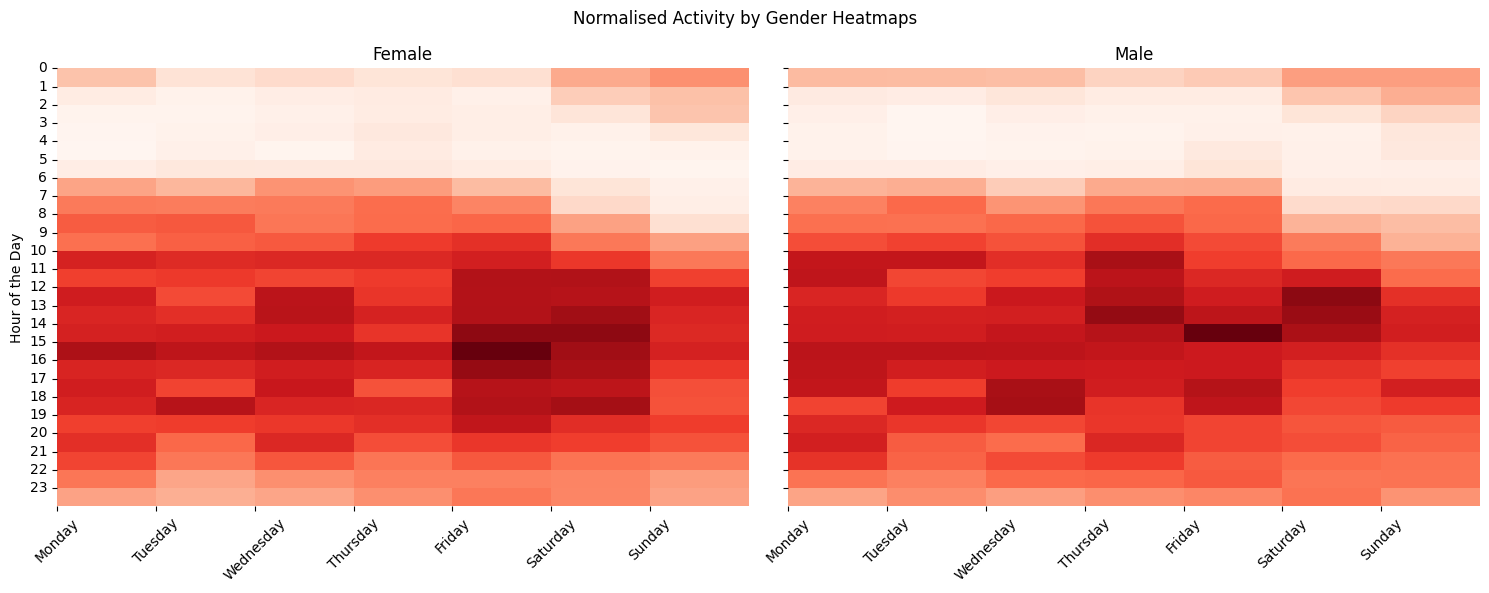

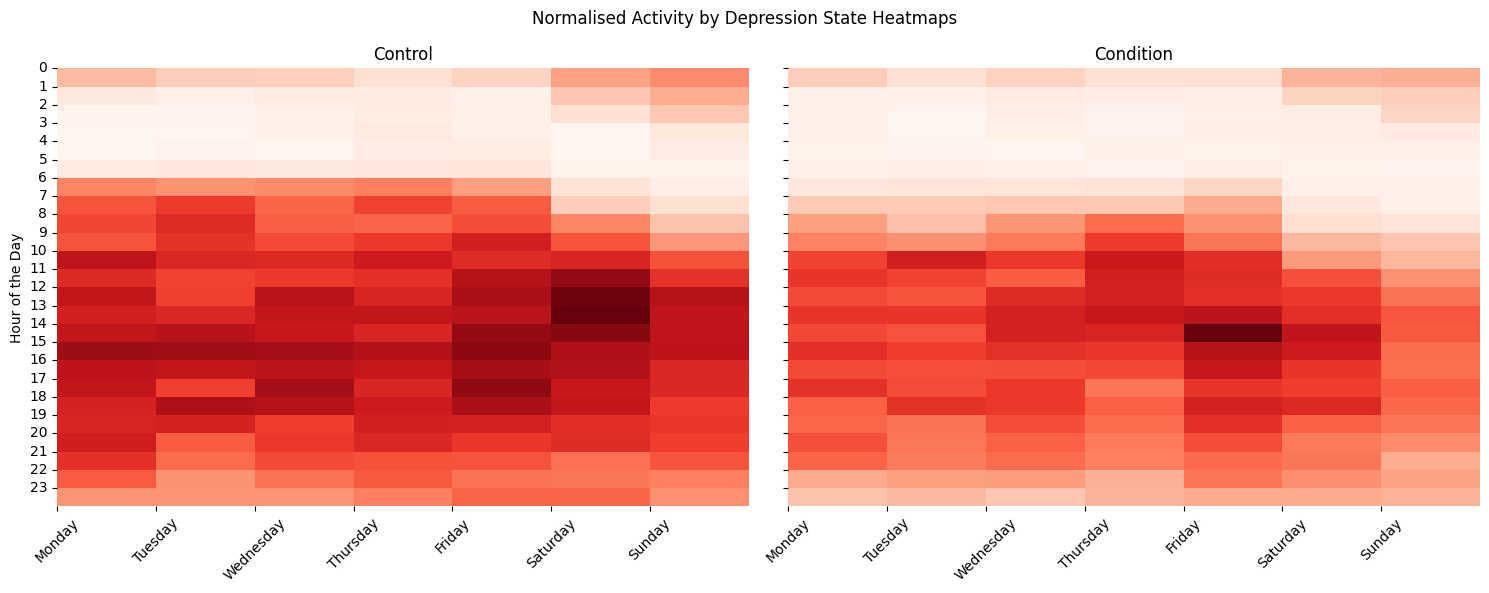

In [11]:
# plot male, female normalised activity heatmaps
plot_heatmap_pair(female_hm_norm, male_hm_norm, df1_title='Female', df2_title='Male', title='Normalised Activity by Gender Heatmaps')

# plot control, condition normalised activity heatmaps
plot_heatmap_pair(control_hm_norm, condition_hm_norm, df1_title='Control', df2_title='Condition', title='Normalised Activity by Depression State Heatmaps')

In [5]:
# list of variable names to delete
hm_dfs = ['control_hm', 'condition_hm', 'female_hm', 'male_hm', 'control_hm_norm', 'condition_hm_norm', 'female_hm_norm', 'male_hm_norm']

# loop over list and delete dfs if they exist
for hm_df in hm_dfs:
    if hm_df in locals():
        del locals()[hm_df]


### Male / Female Activity by Hour of Day

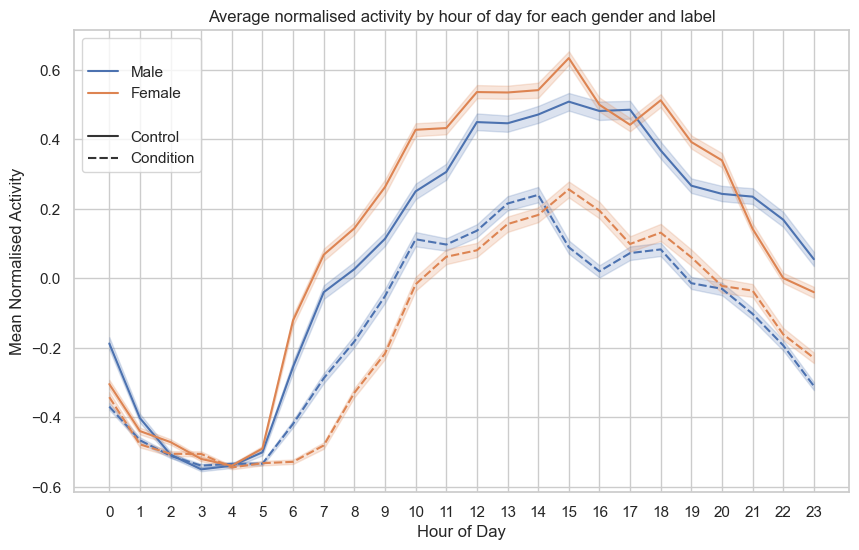

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# map gender and label values to meaningful names
gender_mapping = {1: 'Female', 2: 'Male'}
label_mapping = {0: 'Control', 1: 'Condition'}

# new columns 'gender_name' and 'label_name' with mapped values
df['gender_name'] = df['gender'].map(gender_mapping)
df['label_name'] = df['label'].map(label_mapping)

# plot average normalised activity by hour of day for each gender and label
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="hour_of_day", y="activity_norm", hue="gender_name", style="label_name", data=df)
plt.title("Average normalised activity by hour of day for each gender and label")

plt.xlabel('Hour of Day')
plt.ylabel('Mean Normalised Activity')

plt.xticks(range(0, 24))

# legend
legend = ax.legend()

# remove extra labels
legend.texts[0].set_text('')
legend.texts[1].set_text('Male')
legend.texts[2].set_text('Female')
legend.texts[3].set_text('')

plt.show()

# list of variable names to delete
var_list = ['gender_mapping', 'label_mapping']
# delete variables if they exist
for var in var_list:
    if var in locals():
        del locals()[var]


In [7]:
# df with mean normalied activity per hour of day for each ID
mean_activity_df = df.groupby(['id', 'hour_of_day','label', 'gender_name', 'label_name'])['activity_norm'].mean().reset_index()

In [68]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997920 entries, 0 to 997919
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   timestamp      997920 non-null  datetime64[ns]
 1   date           997920 non-null  datetime64[ns]
 2   activity       997920 non-null  int64         
 3   id             997920 non-null  object        
 4   label          997920 non-null  int64         
 5   gender         997920 non-null  int64         
 6   age            997920 non-null  object        
 7   activity_norm  997920 non-null  float64       
 8   day_of_week    997920 non-null  int64         
 9   hour_of_day    997920 non-null  int64         
 10  gender_name    997920 non-null  object        
 11  label_name     997920 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(5), object(4)
memory usage: 91.4+ MB
None


### Singles


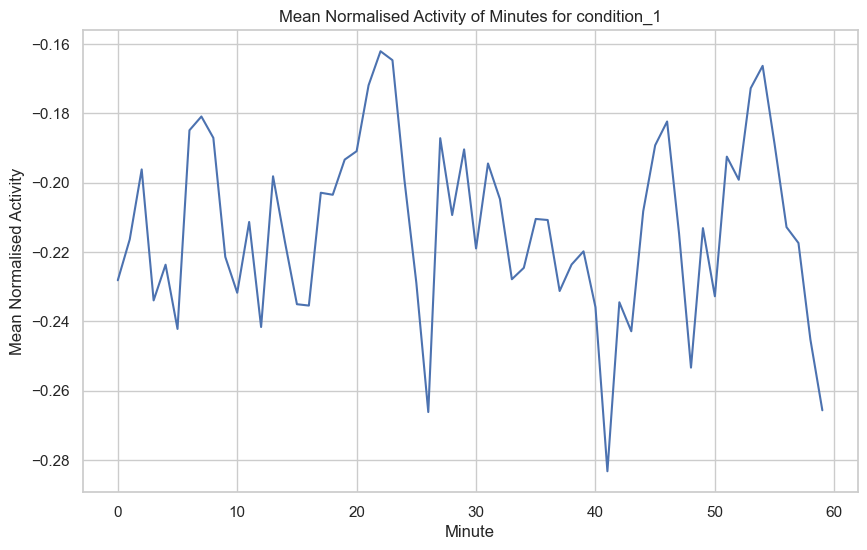

In [16]:
# filter for id = condition_1, control_1
condition_1 = df[df['id'] == 'condition_1']
control_1 = df[df['id'] == 'control_1']

# plot normalised activity by minute for condition_1 and control_1


#  by minute and calculate mean activity
mean_activity = condition_1.groupby(condition_1['timestamp'].dt.minute)['activity_norm'].mean()

# plot
plt.figure(figsize=(10,6))
mean_activity.plot()
plt.xlabel('Minute')
plt.ylabel('Mean Normalised Activity')
plt.title('Mean Normalised Activity of Minutes for condition_1')
plt.show()


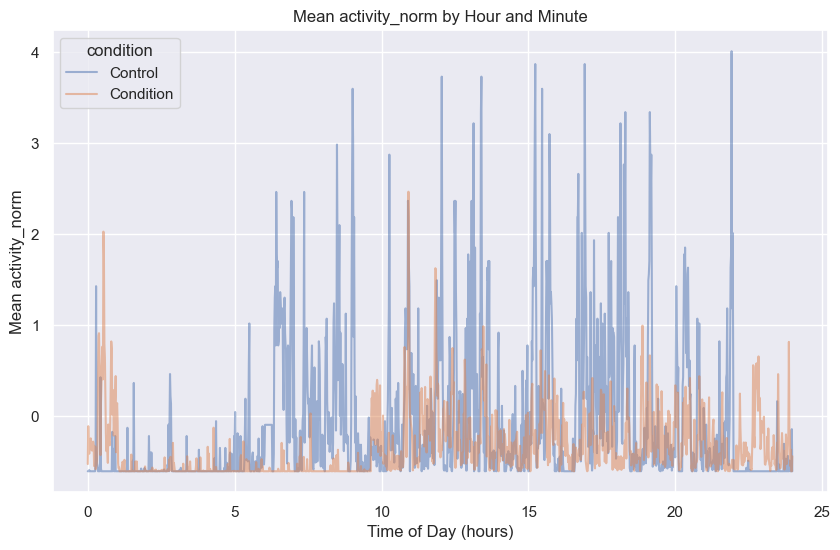

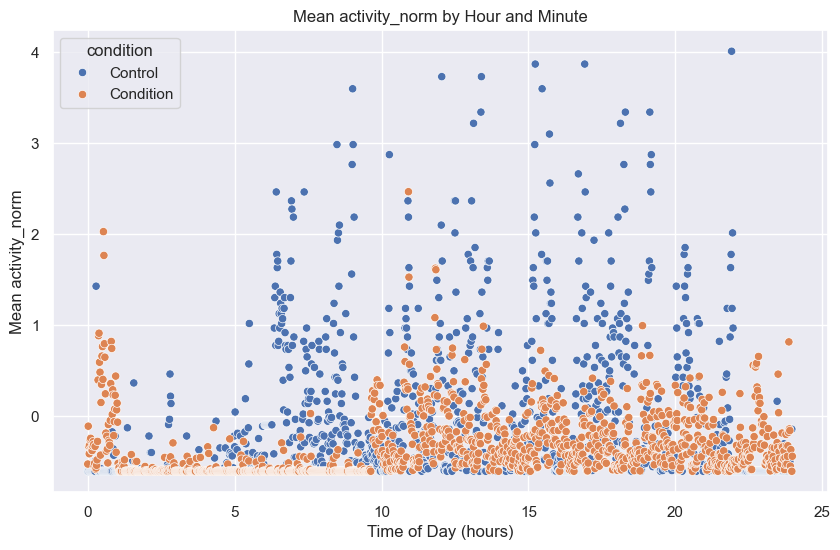

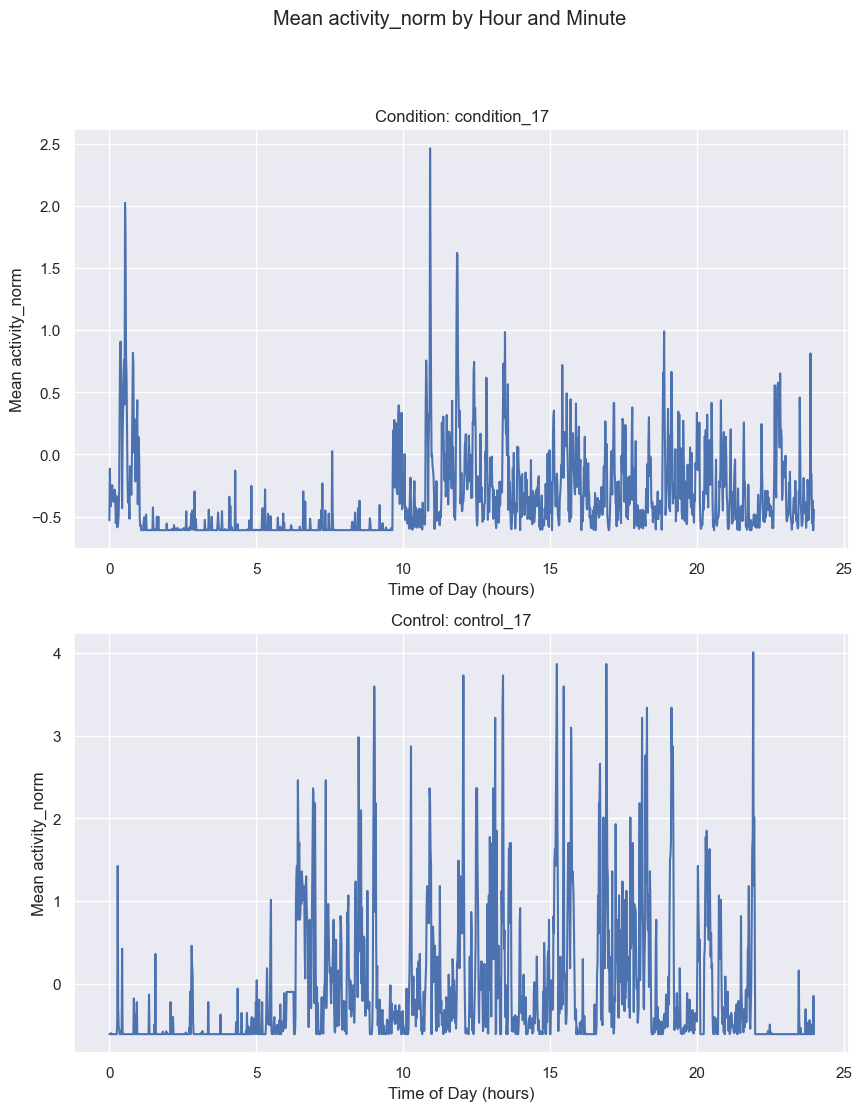

In [62]:
plot_singles(df, 'control_17', 'condition_17', day_of_week=0, first_day=False)

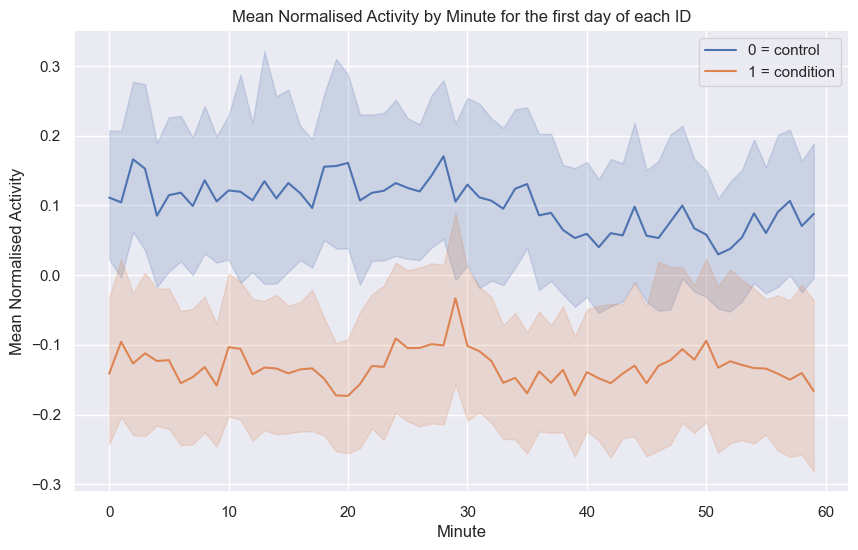

In [64]:
# df with first days of each id
first_days_df = df.groupby(['id']).head(1440)

# group by minute and calculate mean activity
mean_activity = first_days_df.groupby(['id', 'label', first_days_df['timestamp'].dt.minute])['activity_norm'].mean().reset_index()

# plot
plt.figure(figsize=(10,6))
ax = sns.lineplot(x='timestamp', y='activity_norm', hue='label', data=mean_activity)
plt.xlabel('Minute')
plt.ylabel('Mean Normalised Activity')
plt.title('Mean Normalised Activity by Minute for the first day of each ID')

#  plot axis
handles, labels = ax.get_legend_handles_labels()

#  labels
labels = ['0 = control', '1 = condition']

# Set the legend again with the new labels
ax.legend(handles, labels)

plt.show()



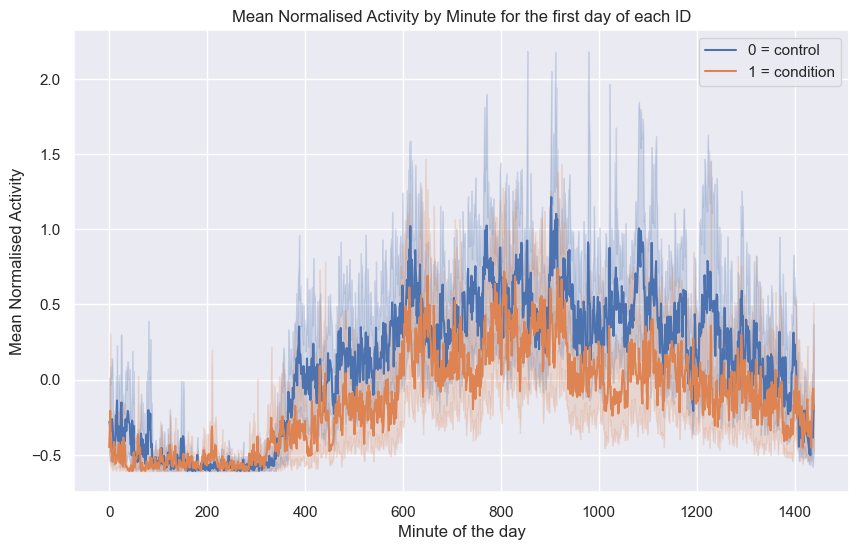

In [66]:
# group by minute and calculate mean activity
mean_activity = first_days_df.copy()
mean_activity['timestamp'] = mean_activity['timestamp'].dt.hour * 60 + mean_activity['timestamp'].dt.minute
mean_activity = mean_activity.groupby(['id', 'label', 'timestamp'])['activity_norm'].mean().reset_index()

# plot
plt.figure(figsize=(10,6))
ax = sns.lineplot(x='timestamp', y='activity_norm', hue='label', data=mean_activity)
plt.xlabel('Minute of the day')
plt.ylabel('Mean Normalised Activity')
plt.title('Mean Normalised Activity by Minute for the first day of each ID')

#  plot axis
handles, labels = ax.get_legend_handles_labels()
#  labels
labels = ['0 = control', '1 = condition']
#  legend with the new labels
ax.legend(handles, labels)

plt.show()


### Time series


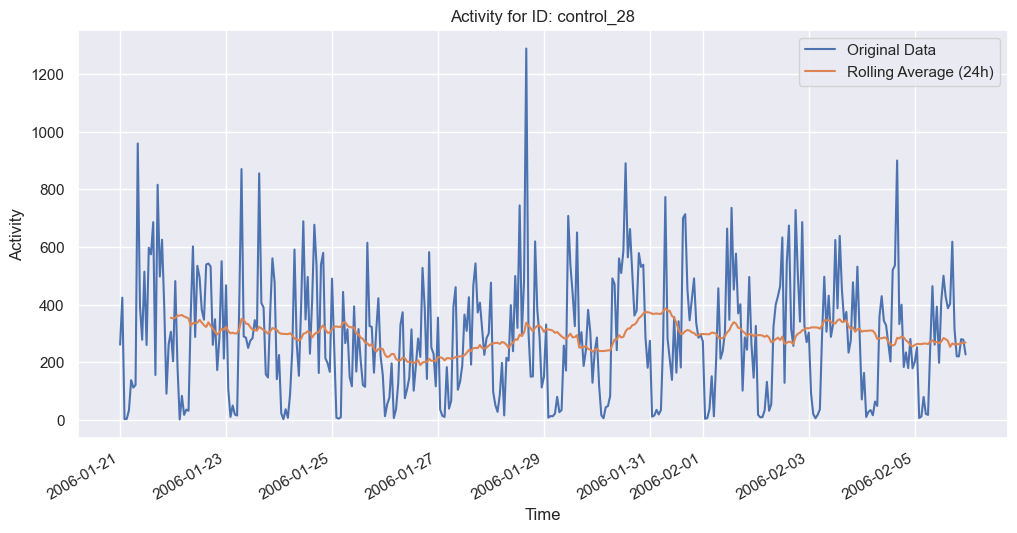

In [157]:
import pandas as pd
import matplotlib.pyplot as plt


# filter data for a specific id
id_to_plot = 'condition_23'
id_to_plot = 'control_28'
data = df[df['id'] == id_to_plot]

# 'timestamp' column to datetime
#data['timestamp'] = pd.to_datetime(data['timestamp'])

# timestamp as the index
data = data.set_index('timestamp')

# resample the data to a specific frequency (e.g., hourly)
resampled_data = data['activity'].resample('h').mean()

# plot the original data
plt.figure(figsize=(12, 6))
plt.plot(resampled_data, label='Original Data')

#  rolling average
rolling_avg = resampled_data.rolling(window=24).mean()  # 24-hour rolling average
plt.plot(rolling_avg, label='Rolling Average (24h)')

#  labels and title
plt.xlabel('Time')
plt.ylabel('Activity')
plt.title(f'Activity for ID: {id_to_plot}')
plt.legend()

# rotate x-axis labels 
plt.gcf().autofmt_xdate()

plt.show()



In [79]:
# count dates per id in df
dates_per_id = df.groupby('id')['date'].nunique()
print(dates_per_id)

id
condition_1     11
condition_10     9
condition_11    14
condition_12    12
condition_13    14
condition_14    14
condition_15    13
condition_16    16
condition_17    13
condition_18    13
condition_19    13
condition_2     18
condition_20    13
condition_21    13
condition_22    14
condition_23    16
condition_3     13
condition_4     13
condition_5     13
condition_6      7
condition_7     11
condition_8      5
condition_9     13
control_1        8
control_10       8
control_11      13
control_12      14
control_13      13
control_14      13
control_15      11
control_16      13
control_17       9
control_18      13
control_19      13
control_2       20
control_20      13
control_21       8
control_22      13
control_23      13
control_24      13
control_25      13
control_26      13
control_27      13
control_28      16
control_29      13
control_3       12
control_30       9
control_31      13
control_32      14
control_4       13
control_5       13
control_6       13
control_7

In [150]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Resample the data to a daily frequency
day2_data = data['activity'].resample('2d').mean()
daily_data = data['activity'].resample('D').mean()
hourly_data = data['activity'].resample('h').mean()
minute_data = data['activity'].resample('min').mean()
data_5min = data['activity'].resample('5min').mean()
data_10min = data['activity'].resample('10min').mean()


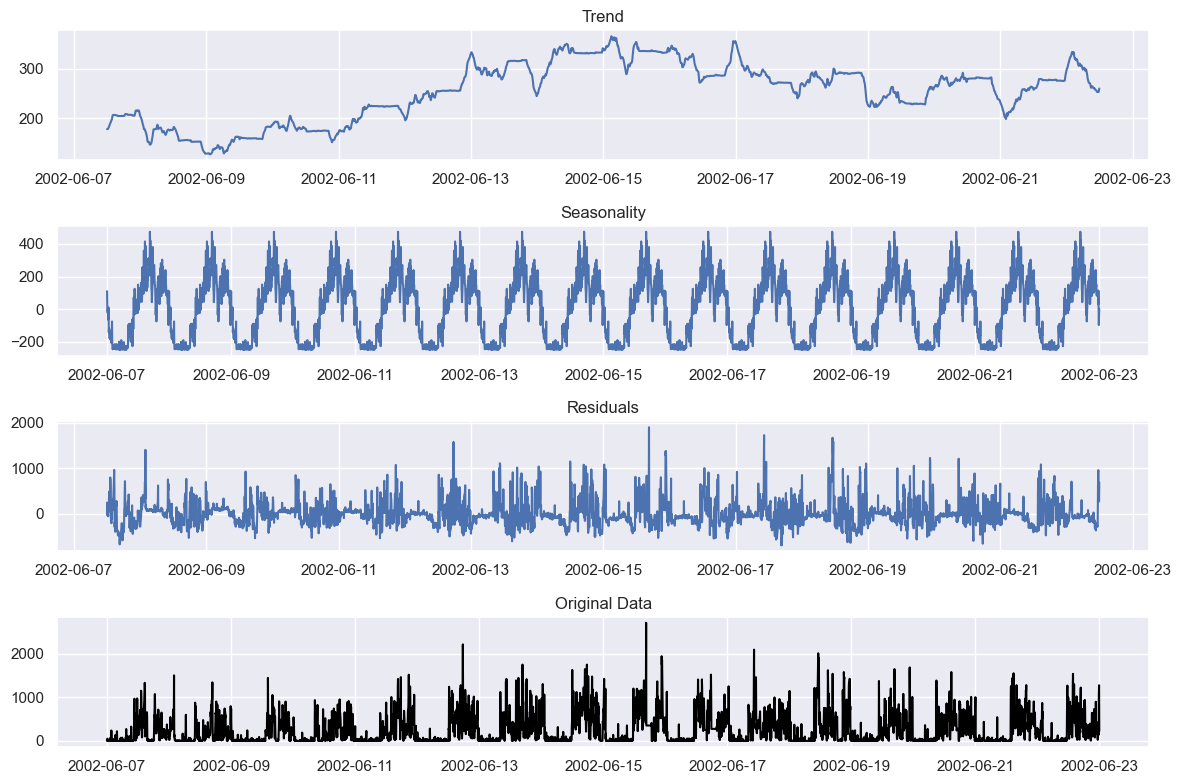

In [154]:

# seasonal decomposition

#day = seasonal_decompose(daily_data, period = 7)
#hour = seasonal_decompose(hourly_data, period=24)  
#minute = seasonal_decompose(minute_data, period = 1440)
#five_min = seasonal_decompose(data_5min, period = 288)
#ten_min = seasonal_decompose(data_10min, period = 144)
minute_day = seasonal_decompose(minute_data, period=8)


# decomposition components
#day.plot()
#hour.plot()
#minute.plot()
#five_min.plot()
#ten_min.plot()
#minute_day.plot()
#plt.show()


decomposition = seasonal_decompose(data_5min, period=288)
# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(decomposition.trend, label='Trend')
plt.title('Trend')

plt.subplot(4, 1, 2)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.title('Seasonality')

plt.subplot(4, 1, 3)
plt.plot(decomposition.resid, label='Residuals')
plt.title('Residuals')

plt.subplot(4, 1, 4)
plt.plot(data_5min, label='Original Data', color='black')
plt.title('Original Data')

plt.tight_layout()
plt.show()

In [142]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Ensure 'date' column is of datetime type
df['date'] = pd.to_datetime(df['date'])

# Group data by label, date, and hour of the day
grouped = df.groupby(['label', 'date', df['timestamp'].dt.hour])

# Group data by label, date, and hour of the day and calculate the mean of 'activity' within each group
grouped = df.groupby(['label', 'date', df['timestamp'].dt.hour]).agg({'activity': 'mean'}).reset_index()



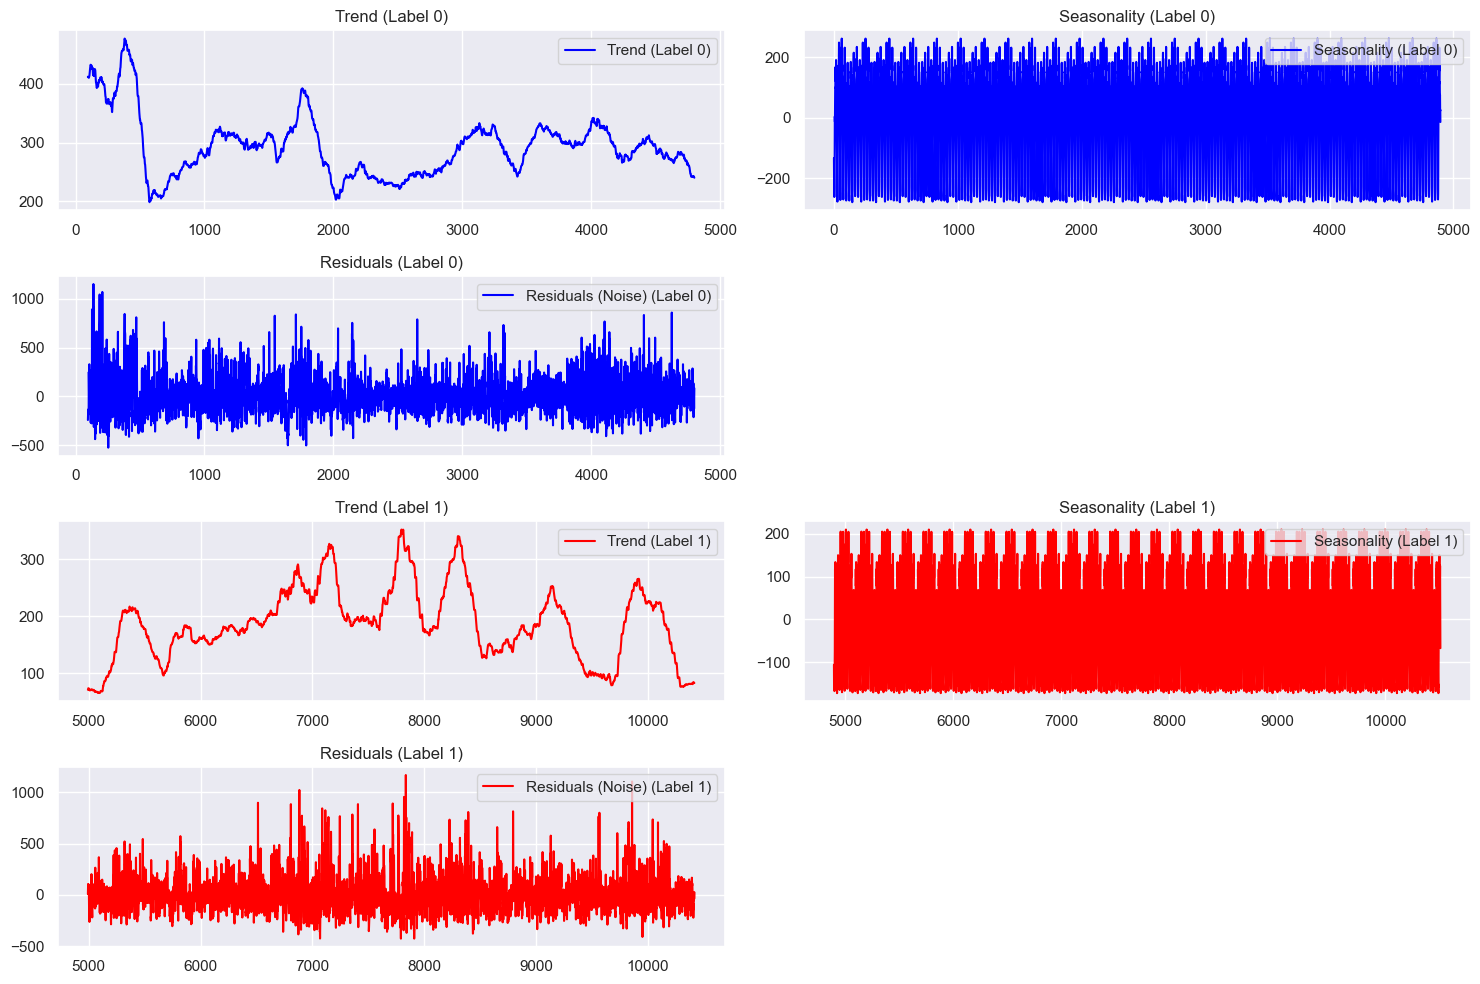

In [149]:

# Filter for label 0 and label 1
control = grouped[grouped['label'] == 0]
condition = grouped[grouped['label'] == 1]

# Perform seasonal decomposition for label 0
decomp_control = seasonal_decompose(control['activity'], model='additive', period=192)
# Perform seasonal decomposition for label 1
decomp_condition = seasonal_decompose(condition['activity'], model='additive', period=192)

# Plot the components side by side for comparison
plt.figure(figsize=(15, 10))

# Plot decompositions for Label 0
plt.subplot(4, 2, 1)
plt.plot(decomp_control.trend, label='Trend (Label 0)', color='blue')
plt.title('Trend (Label 0)')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(decomp_control.seasonal, label='Seasonality (Label 0)', color='blue')
plt.title('Seasonality (Label 0)')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(decomp_control.resid, label='Residuals (Noise) (Label 0)', color='blue')
plt.title('Residuals (Label 0)')
plt.legend()

# Plot decompositions for Label 1
plt.subplot(4, 2, 5)
plt.plot(decomp_condition.trend, label='Trend (Label 1)', color='red')
plt.title('Trend (Label 1)')
plt.legend()

plt.subplot(4, 2, 6)
plt.plot(decomp_condition.seasonal, label='Seasonality (Label 1)', color='red')
plt.title('Seasonality (Label 1)')
plt.legend()

plt.subplot(4, 2, 7)
plt.plot(decomp_condition.resid, label='Residuals (Noise) (Label 1)', color='red')
plt.title('Residuals (Label 1)')
plt.legend()

plt.tight_layout()
plt.show()


### Visualisations

In [9]:
import pandas as pd
import plotly.express as px

# group by 'gender_name', 'label_name', and 'hour_of_day'
grouped = df.groupby(['gender_name', 'label_name', 'hour_of_day'])['activity'].mean().reset_index()

# interactive line plot
fig = px.line(grouped, x='hour_of_day', y='activity', color='gender_name', line_group='label_name', line_shape='spline', line_dash='label_name')

# update the layout
fig.update_layout(
    title='Average Activity over Time by Gender and Label',
    xaxis_title='Hour of Day',
    yaxis_title='Activity',
    legend_title='Gender',
    hovermode='x unified'
)
# display
fig.show()

In [10]:
import pandas as pd
import plotly.express as px

# group by 'gender_name', 'label_name', and 'hour_of_day'
grouped = df.groupby(['hour_of_day', 'gender_name', 'label_name'])['activity'].mean().reset_index()

# ridgeline plot
fig = px.line(grouped, x='activity', y='hour_of_day', color='gender_name', line_group='label_name', line_shape='linear', line_dash='label_name')

# update the layout
fig.update_layout(
    title='Activity over Time by Gender and Label (Ridgeline Plot)',
    xaxis_title='Activity',
    yaxis_title='Hour of Day',
    legend_title='Gender'
)

# display 
fig.show()

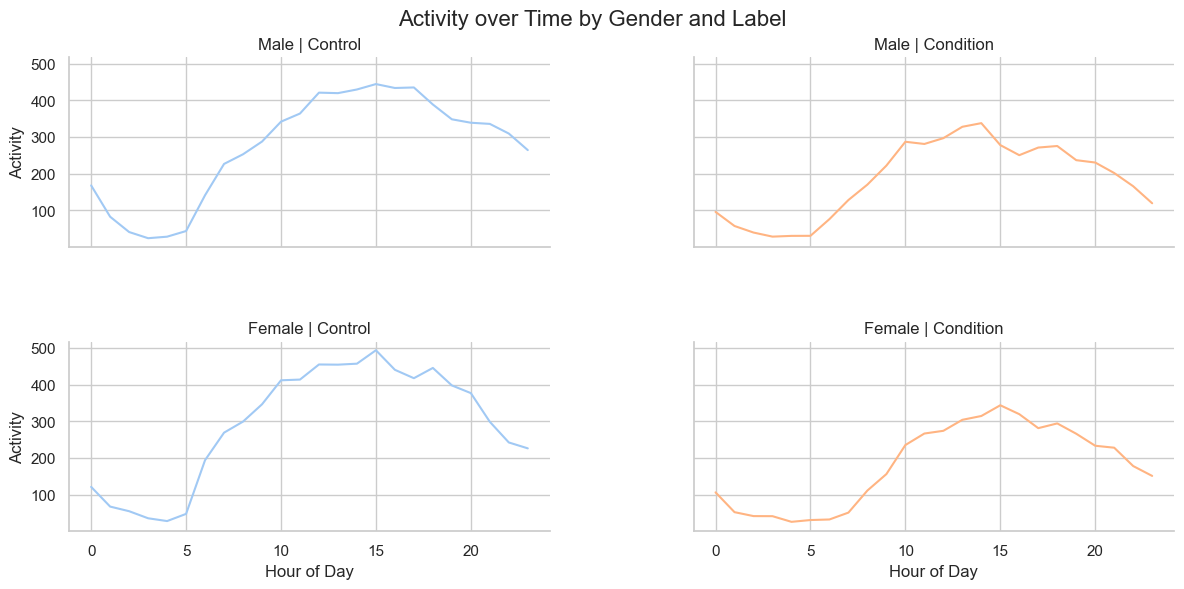

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# facet grid, rows for gender_name and columns for label_name
# set aspect=1 to ensure all plots have the same width
grid = sns.FacetGrid(df, row="gender_name", col="label_name", height=3, aspect=2, hue="label_name", palette='pastel')

# map line plots to grid
grid.map(sns.lineplot, "hour_of_day", "activity", errorbar=None)

# set axis labels and titles
grid.set_axis_labels('Hour of Day', 'Activity')
grid.set_titles(row_template='{row_name}', col_template='{col_name}', size=12)
plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.5)
grid.figure.suptitle('Activity over Time by Gender and Label', fontsize=16)

# display
plt.show()

In [12]:
plotly_24_hours(mean_activity_df, 'label_name', ['Control', 'Condition'])

plotly_24_hours(mean_activity_df, 'gender_name', ['Female', 'Male'])

In [19]:
# list of variable names to delete
var_list = ['mean_activity_df', 'grouped', 'grid', 'fig']
# delete variables if they exist
for var in var_list:
    if var in locals():
        del locals()[var]

### Descriptive statistics


In [20]:
# create people df
people = df[['id', 'age', 'gender_name', 'label_name']].drop_duplicates()

people2 = df[['id', 'age', 'gender_name', 'label_name', 'date', 'activity', 'activity_norm']].drop_duplicates()

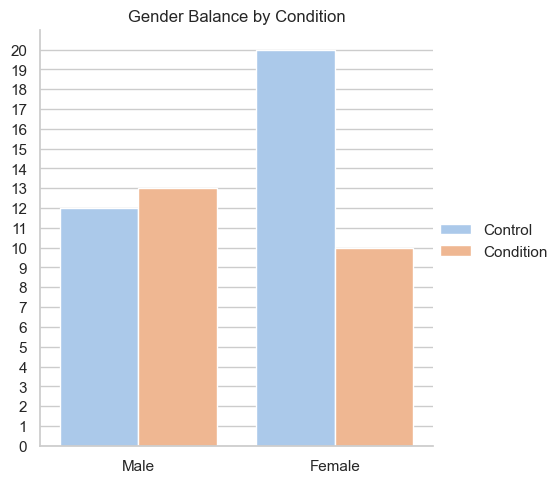

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.catplot(x="gender_name", hue="label_name", kind="count", palette='pastel', data=people, legend=True)
# title 
plt.title('Gender Balance by Condition')

# remove labels
plt.ylabel('')
plt.xlabel('')
ax._legend.set_title('')

# yticks from 0 to 20
ax.set(yticks=range(0, 21))
ax.set_yticklabels(range(0, 21))  # set ytick labels

# plot
plt.show()

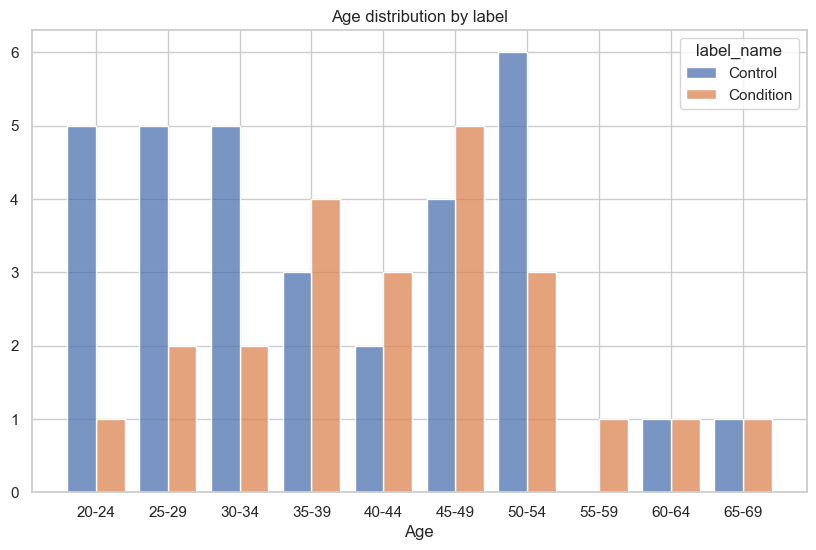

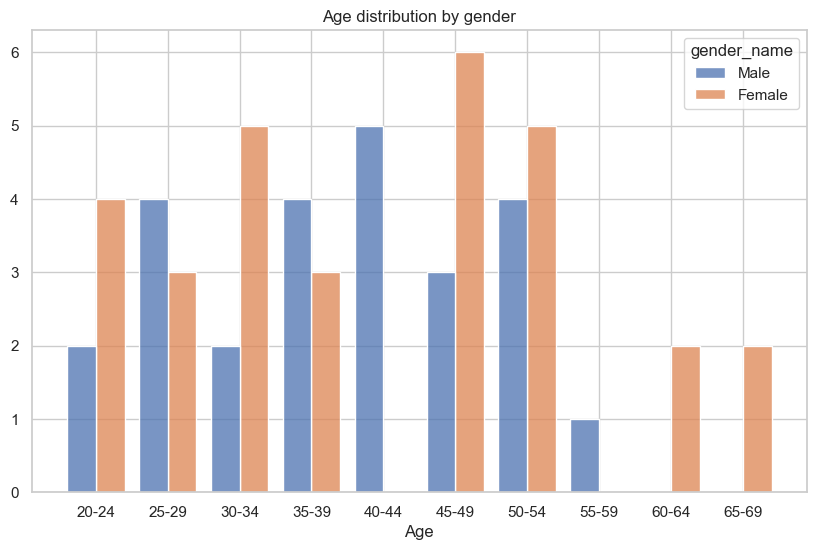

In [22]:
import seaborn as sns
# age correct order
age_order = ['20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69']

# 'age' column to a category type 
people['age'] = pd.Categorical(people['age'], categories=age_order, ordered=True)

import matplotlib.pyplot as plt
# 'age' column to a category type 
people['age'] = pd.Categorical(people['age'], categories=age_order, ordered=True)

# create a new figure for the first plot
plt.figure(figsize=(10, 6))
sns.histplot(data=people, x='age', hue='label_name', multiple='dodge', shrink=.8)
plt.title('Age distribution by label')
plt.xlabel('Age')
plt.ylabel('')
plt.show()

# create a new figure for the second plot
plt.figure(figsize=(10, 6))
sns.histplot(data=people, x='age', hue='gender_name', multiple='dodge', shrink=.8)
plt.title('Age distribution by gender')
plt.xlabel('Age')
plt.ylabel('')
plt.show()

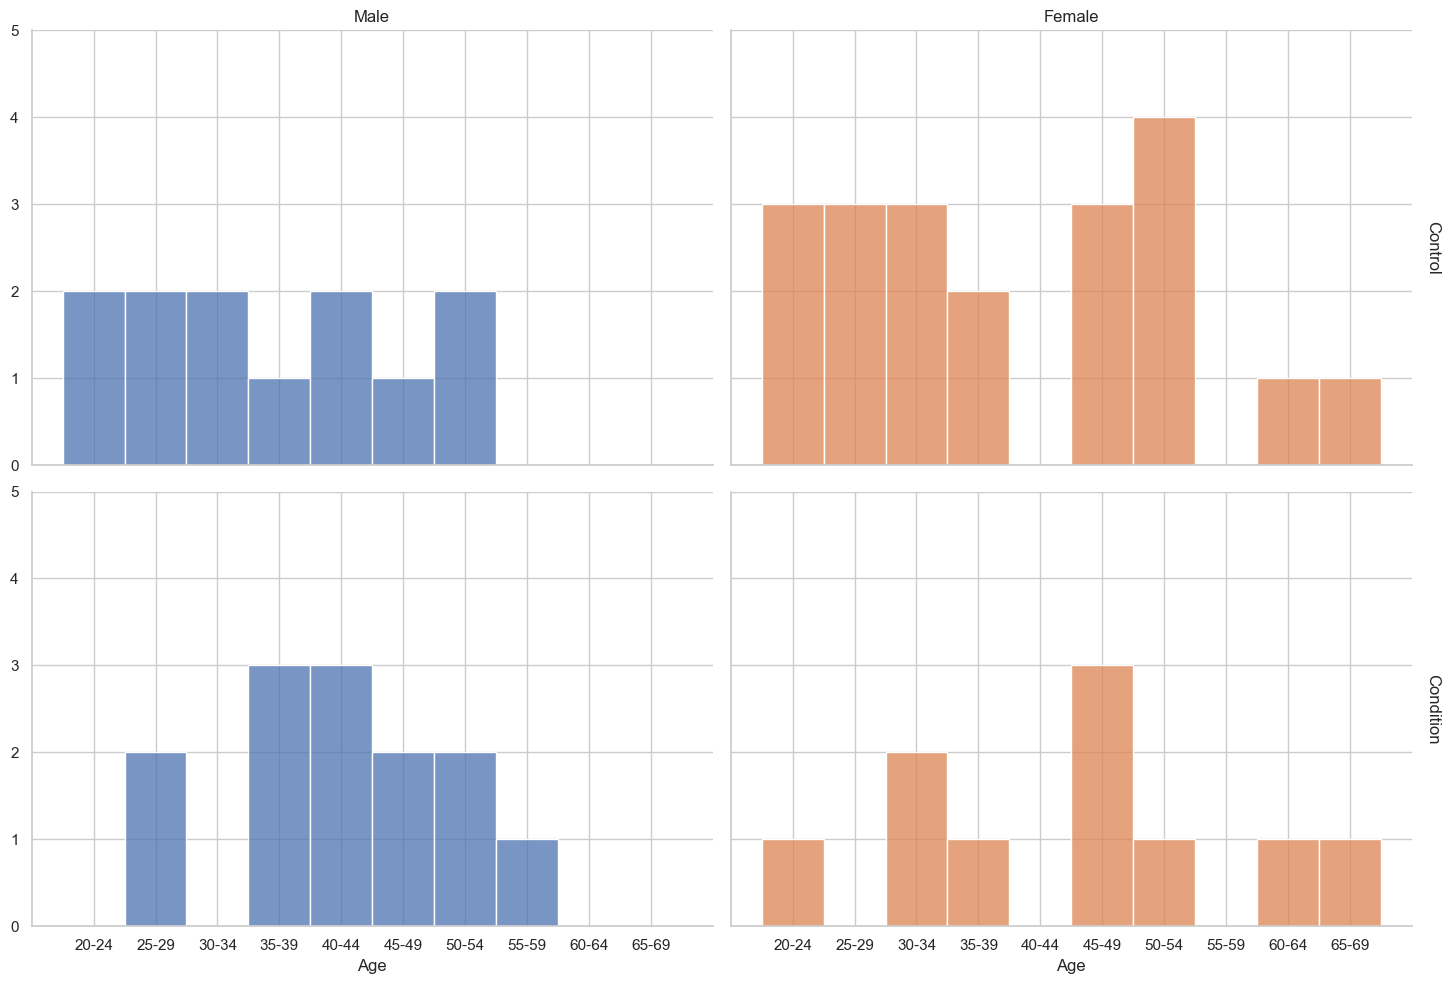

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# set style
sns.set_theme(style="whitegrid")

# facet grid 
g = sns.FacetGrid(people, col='gender_name', row='label_name', hue='gender_name', margin_titles=True, height=5, aspect=1.5)

# histogram to each facet
g.map(sns.histplot, 'age', bins=20)

# set y-axis ticks
for ax in g.axes.flat:
    ax.set_yticks([0, 1, 2, 3, 4, 5])

# legend
#g.add_legend(title='Gender')

# axis labels
g.set_axis_labels('Age', '')

# facet titles
g.set_titles(col_template='{col_name}', row_template='{row_name}')

plt.show()

In [24]:
# male, female dfs
male = people2[people2['gender_name'] == 'Male']
female = people2[people2['gender_name'] == 'Female']

# print count of unique male ids for each label
print("Count of Male Condition/Control IDs:\n")
print("Control: ", len(male[male['label_name']=='Control']['id'].unique()))
print("Condition: ", len(male[male['label_name']=='Condition']['id'].unique()))

# print count of unique female ids for each label
print("\nCount of Female Condition/Control IDs:\n")
print("Control: ", len(female[female['label_name']=='Control']['id'].unique()))
print("Condition: ", len(female[female['label_name']=='Condition']['id'].unique()))

# count of condition/control days for Male
print("\nCount of Male Condition/Control Days:\n")
print("Control: ", len(male[male['label_name']=='Control'].groupby(['id', 'date']).count()))
print("Condition: ", len(male[male['label_name']=='Condition'].groupby(['id', 'date']).count()))

# count of condition/control days for Male
print("\nCount of Female Condition/Control Days:\n")
print("Control: ", len(female[female['label_name']=='Control'].groupby(['id', 'date']).count()))
print("Condition: ", len(female[female['label_name']=='Condition'].groupby(['id', 'date']).count()))



Count of Male Condition/Control IDs:

Control:  12
Condition:  13

Count of Female Condition/Control IDs:

Control:  20
Condition:  10

Count of Male Condition/Control Days:

Control:  150
Condition:  160

Count of Female Condition/Control Days:

Control:  252
Condition:  131


In [25]:
# descriptive statistics for 'male' dataframe
male_desc = male.describe()[['activity', 'activity_norm']]

# descriptive statistics for 'female' dataframe
female_desc = female.describe()[['activity', 'activity_norm']]

# display 
print("Male Descriptive Statistics:")
display(male_desc)
print("\nFemale Descriptive Statistics:")
display(female_desc)


Male Descriptive Statistics:


,activity,activity_norm
count,42347.000000,42347.000000
mean,458.046190,0.542786
min,0.000000,-0.608955
25%,55.000000,-0.470659
50%,205.000000,-0.093490
75%,626.000000,0.965100
max,8000.000000,19.506752
std,617.196121,1.551917



Female Descriptive Statistics:


,activity,activity_norm
count,52193.000000,52193.000000
mean,475.142241,0.585773
min,0.000000,-0.608955
25%,59.000000,-0.460601
50%,216.000000,-0.065830
75%,662.000000,1.055620
max,8000.000000,19.506752
std,623.810348,1.568548


### T-test between groups

In [26]:
# evaluate if there isa statistical differene between genders with t-test
from scipy.stats import ttest_ind
alpha = 0.05

# t-test for activity
t_stat_activity, p_val_activity = ttest_ind(df[df['gender_name']=='Female']['activity'], df[df['gender_name']=='Male']['activity'])
print(f"Activity: t-statistic = {t_stat_activity:.2f}, p-value = {p_val_activity:.2f}")
if p_val_activity < alpha:
    print("Reject the null hypothesis: There is a significant difference between the activity means of the two groups.")

# t-test for normalised activity
t_stat_norm, p_val_norm = ttest_ind(df[df['gender_name']=='Female']['activity_norm'], df[df['gender_name']=='Male']['activity_norm'])
print(f"\nNormalised Activity: t-statistic = {t_stat_norm:.2f}, p-value = {p_val_norm:.2f}")
if p_val_norm < alpha:
    print("Reject the null hypothesis: There is a significant difference between the normalised activity means of the two groups.")

Activity: t-statistic = 32.58, p-value = 0.00
Reject the null hypothesis: There is a significant difference between the activity means of the two groups.

Normalised Activity: t-statistic = 32.58, p-value = 0.00
Reject the null hypothesis: There is a significant difference between the normalised activity means of the two groups.


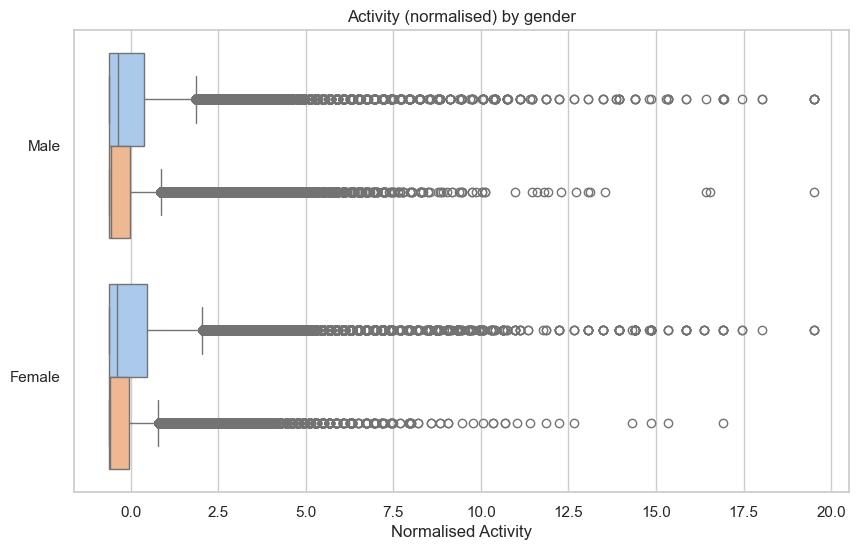

In [27]:
# box plots of activity_norm by gender
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(y="gender_name", x="activity_norm", data=df, hue = 'label_name', legend= False, palette='pastel', orient='h')
# labels
#ax.set_yticks([1, 2]) 
#ax.set_yticklabels(['Female', 'Male'])
# remove the y-axis label
ax.set_ylabel('') 
ax.set_xlabel('Normalised Activity')
plt.title("Activity (normalised) by gender")
plt.show()


In [28]:
# list of variable names to delete
var_list = ['people', 'people2', 'ax', 'age_order', 'g', 'male', 'female', 'male_desc', 'female_desc', 't_stat_activity', 'p_val_activity', 't_stat_norm', 'p_val_norm', 'df', 'alpha']
# delete variables if they exist
for var in var_list:
    if var in locals():
        del locals()[var]